In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')

In [233]:
df = pd.read_csv('mishnah.csv')
df.drop(columns='Unnamed: 0',inplace=True)

Text(0, 0.5, 'Opinion Count')

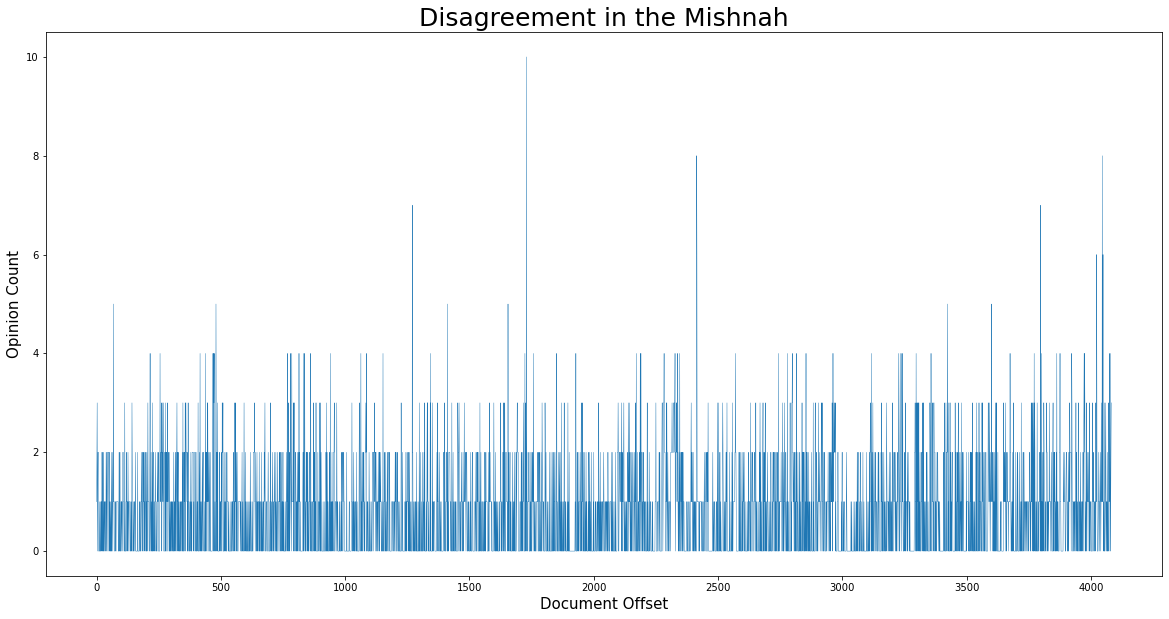

In [234]:
plt.figure(figsize=(20,10))
plt.plot(df.index,df.tanna_count,linewidth=0.45)
plt.title('Disagreement in the Mishnah', fontsize=25)
plt.xlabel('Document Offset',fontsize=15)
plt.ylabel('Opinion Count',fontsize=15)

In [412]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4083 entries, 0 to 4082
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tractate     4083 non-null   object
 1   chapter      4083 non-null   int64 
 2   mishnah      4083 non-null   int64 
 3   text         4083 non-null   object
 4   seder        4083 non-null   object
 5   tannaim      4083 non-null   object
 6   tanna_count  4083 non-null   int64 
 7   spacy_doc    4083 non-null   object
 8   tokens       4083 non-null   object
dtypes: int64(3), object(6)
memory usage: 287.2+ KB


In [498]:
from sklearn.feature_extraction.text import TfidfVectorizer
def mach_score(row):
    opinions=[]
    rabbis = row.tannaim
    for char in ['[',']','\'',]:
        rabbis = rabbis.replace(char,'')
    rabbis = rabbis.split(',')
    for i in range(0,len(rabbis)):
        rabbis[i]= rabbis[i].strip()
    rabbis.extend(['Rabbis ','Sages ','sages '])
    if '' in rabbis:
        rabbis.pop(rabbis.index(''))
    for sentence in row.text.split('.'):
        for name in rabbis:
            if (name in sentence)and(sentence not in opinions):
                if 'Rabbi' in sentence:
                    if ('the words of'in sentence):
                        sentence = sentence.split('the words of')[0]
                    else:
                        sentence = sentence.split(name)[1]
                opinions.append(str(sentence))
    
    docs =[]
    for i in opinions:
        doc=nlp(i)
        new_text = ''
        for token in doc:
            if token.lemma_ != '-PRON-':
                new_text+=token.lemma_+' '
            else:
                new_text+=token.text+' '
        docs.append(str(nlp(new_text)))
    if len(docs)>1:
        tfidf = TfidfVectorizer().fit_transform(docs)
        pairwise_similarity = tfidf * tfidf.T
        full = pairwise_similarity.toarray()
        full = full[np.triu_indices(len(full), k = 1)]
        return np.mean(full)
    else:
        return 1

df['mach_score'] = df.apply(lambda row: mach_score(row),axis=1)

Text(0, 0.5, 'Mach Score')

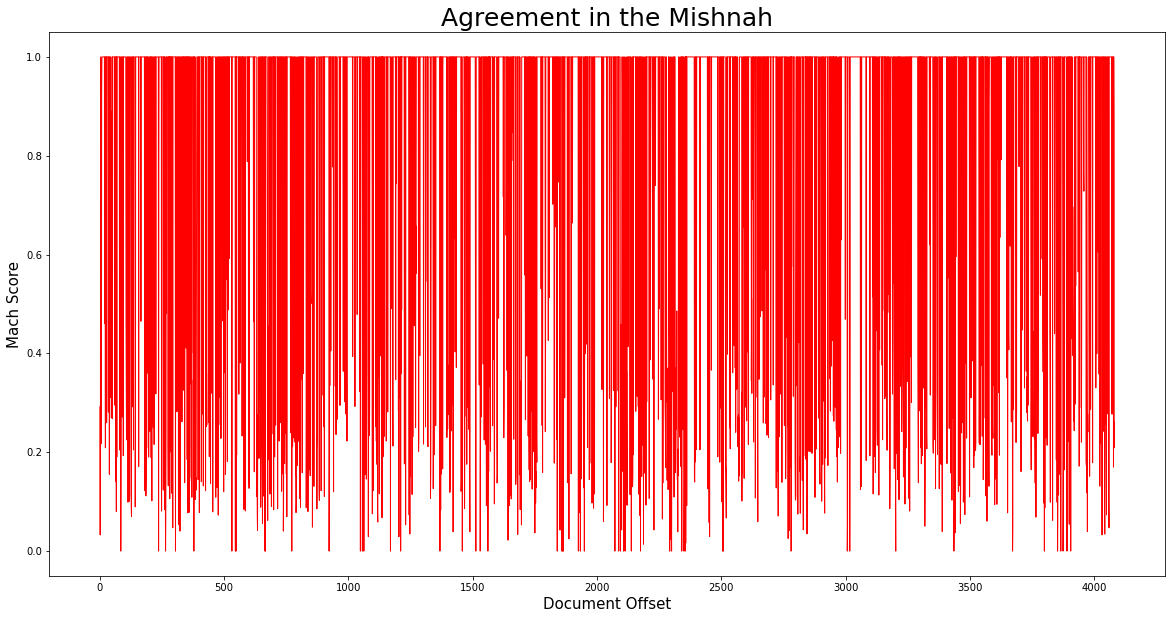

In [525]:
plt.figure(figsize=(20,10))
sns.lineplot(df.index,"mach_score",data=df,linewidth=1,color='r',estimator='mean')
plt.title('Agreement in the Mishnah', fontsize=25)
plt.xlabel('Document Offset',fontsize=15)
plt.ylabel('Mach Score',fontsize=15)

Text(0, 0.5, 'Mach Score')

<Figure size 1440x720 with 0 Axes>

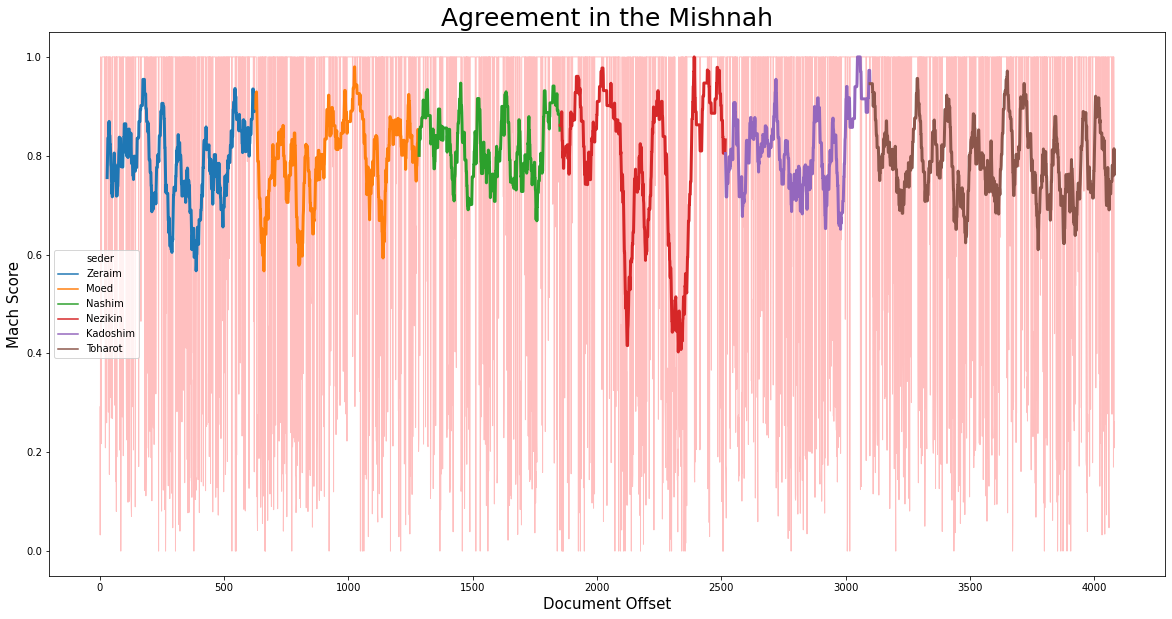

In [542]:
df['rolling_mach_score'] = df.mach_score.rolling(30).mean()
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(df.index,"mach_score",data=df,linewidth=1,color='r',ax=ax,alpha=0.25)
sns.lineplot(df.index,"rolling_mach_score",hue='seder',data=df,linewidth=3,color='b',ax=ax)
plt.title('Agreement in the Mishnah', fontsize=25)
plt.xlabel('Document Offset',fontsize=15)
plt.ylabel('Mach Score',fontsize=15)

Text(0, 0.5, 'Opinion Count')

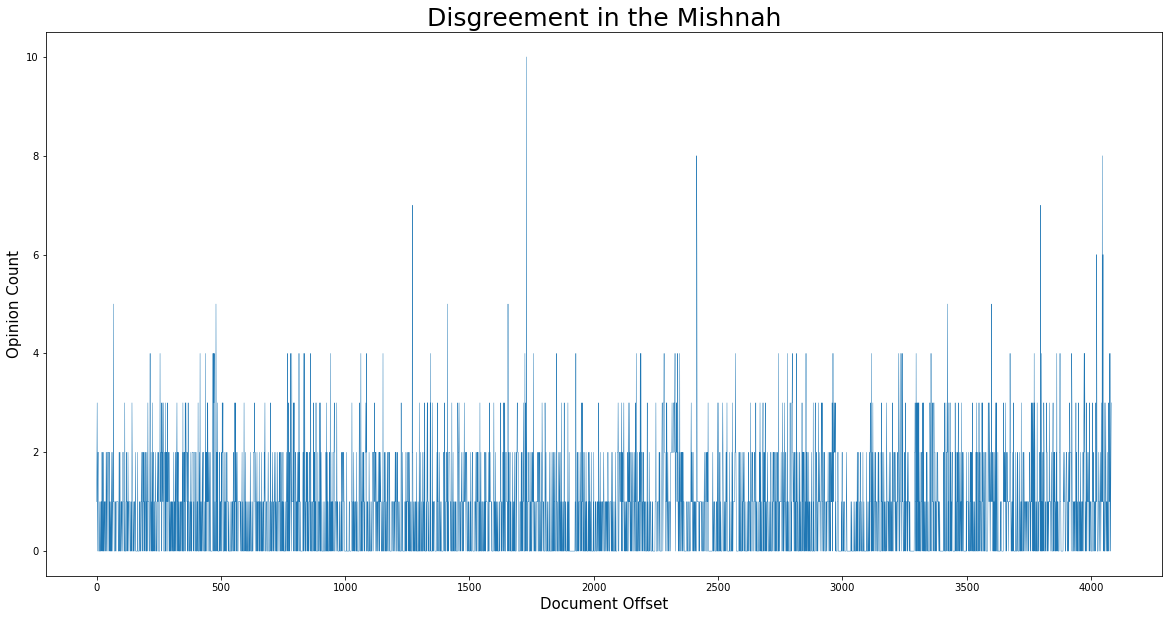

In [510]:
plt.figure(figsize=(20,10))
plt.plot(df.index,df.tanna_count,linewidth=0.45)
plt.title('Disgreement in the Mishnah', fontsize=25)
plt.xlabel('Document Offset',fontsize=15)
plt.ylabel('Opinion Count',fontsize=15)

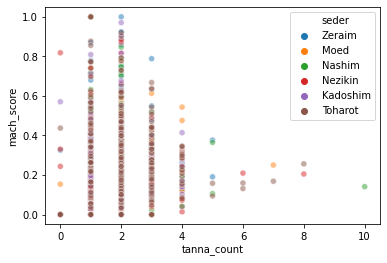

In [456]:
sns.scatterplot('tanna_count','mach_score',hue='seder',data=df,alpha=0.5)

In [485]:
count=0
for i in range(0,1000):
    sample_df = df.sample(500,random_state=i)
    if np.corrcoef(sample_df.tanna_count,sample_df.mach_score)[0,1]>.488:
        count+=1
print(count/1000)

0.95


In [497]:
np.corrcoef(sample_df.mach_score,sample_df.tanna_count)

array([[1.        , 0.54170135],
       [0.54170135, 1.        ]])